In [11]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")

def fix_datetime(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    # Drop rows where the minute part of the time is not 0
    X = X[X.index.minute == 0]
    return X



def convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_datetime(X_train_observed, "X_train_observed")
    X_train_estimated = fix_datetime(X_train_estimated, "X_train_estimated")
    X_test = fix_datetime(X_test, "X_test")


    X_train_observed["estimated_diff_hours"] = 0
    X_train_observed["is_estimated"] = False
    X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
    X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600
    
    X_train_estimated["is_estimated"] = True
    X_test["is_estimated"] = True

    X_train_estimated["estimated_diff_hours"] = X_train_estimated["estimated_diff_hours"].astype('int64')
    # the filled once will get dropped later anyways, when we drop y nans
    X_test["estimated_diff_hours"] = X_test["estimated_diff_hours"].fillna(-50).astype('int64')


    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train)

    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)

    X_train = pd.concat([X_train_observed, X_train_estimated, X_train_estimated, X_train_estimated, X_train_estimated, X_train_estimated], axis=0)
    # weight the estimated X_train higher

    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="outer", left_index=True, right_index=True)

    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)

Processing location A...
Processing location B...
Processing location C...


# Feature enginering

In [12]:
# temporary
X_train["hour"] = X_train.index.hour
X_train["weekday"] = X_train.index.weekday
X_train["month"] = X_train.index.month
X_train["year"] = X_train.index.year

X_test["hour"] = X_test.index.hour
X_test["weekday"] = X_test.index.weekday
X_test["month"] = X_test.index.month
X_test["year"] = X_test.index.year


to_drop = ["snow_drift:idx", "snow_density:kgm3"]

X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.dropna(subset=['y'], inplace=True)
X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

**`train_data` dataset summary**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
absolute_humidity_2m:gm3,136651,165,,,5.463406,2.526241,0.5,3.7,4.9,6.9,17.5,float32,73,0.000534,float,numeric,
air_density_2m:kgm3,136651,293,,,1.262643,0.035762,1.139,1.238,1.263,1.285,1.441,float32,73,0.000534,float,numeric,
ceiling_height_agl:m,104000,40993,,,2936.124268,2539.34668,27.799999,1061.400024,1974.099976,4185.275391,12431.299805,float32,32724,0.239343,float,numeric,
clear_sky_energy_1h:J,136651,48602,,,435987.8125,753586.4375,0.0,0.0,0.0,552515.3125,3006697.25,float32,73,0.000534,float,numeric,
clear_sky_rad:W,136651,7815,,,121.115158,209.874939,0.0,0.0,0.0,152.199997,835.299988,float32,73,0.000534,float,numeric,
cloud_base_agl:m,121212,34862,,,1666.626587,1796.03125,27.4,539.900024,1065.0,1980.5,11688.900391,float32,15512,0.113455,float,numeric,
dew_or_rime:idx,136651,3,,,0.00431,0.253486,-1.0,0.0,0.0,0.0,1.0,float32,73,0.000534,float,category,
dew_point_2m:K,136651,436,,,273.853149,6.624437,247.300003,269.399994,273.5,278.5,293.799988,float32,73,0.000534,float,numeric,
diffuse_rad:W,136651,2870,,,34.930195,57.239651,0.0,0.0,0.0,55.5,340.100006,float32,73,0.000534,float,numeric,
diffuse_rad_1h:J,136651,48553,,,125727.84375,203732.015625,0.0,0.0,0.0,198568.3125,1182265.375,float32,73,0.000534,float,numeric,


**`test_data` dataset summary**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
absolute_humidity_2m:gm3,2160,106,,,8.206482,2.201396,3.2,6.6,8.0,10.0,14.2,float32,,,float,numeric,
air_density_2m:kgm3,2160,153,,,1.232807,0.032116,1.142,1.209,1.238,1.26,1.301,float32,,,float,numeric,
ceiling_height_agl:m,1473,1391,,,2938.389648,2913.641113,30.6,891.799988,1553.900024,4021.300049,11468.0,float32,687,0.318056,float,numeric,
clear_sky_energy_1h:J,2160,1807,,,1227746.75,1104468.625,0.0,64338.124023,1056303.125,2372037.5,3005707.0,float32,,,float,numeric,
clear_sky_rad:W,2160,1044,,,341.056641,307.729095,0.0,13.65,273.849991,646.874985,835.099976,float32,,,float,numeric,
cloud_base_agl:m,1879,1771,,,1797.160156,2046.394409,29.799999,486.899994,997.799988,2298.300049,11467.799805,float32,281,0.130093,float,numeric,
dew_or_rime:idx,2160,3,,,0.040741,0.202365,-1.0,0.0,0.0,0.0,1.0,float32,,,float,category,
dew_point_2m:K,2160,202,,,280.783203,4.378817,268.0,277.899994,281.0,284.299988,290.200012,float32,,,float,numeric,
diffuse_rad:W,2160,985,,,84.915688,78.422508,0.0,6.925,73.700001,135.600006,312.600006,float32,,,float,numeric,
diffuse_rad_1h:J,2160,1806,,,305696.5,278146.25,0.0,36756.901367,272526.046875,488256.03125,1086246.25,float32,,,float,numeric,


**Types warnings summary**

,train_data,test_data,warnings
estimated_diff_hours,float,int,warning
is_estimated,object,bool,warning
y,float,--,warning


### Feature Distance

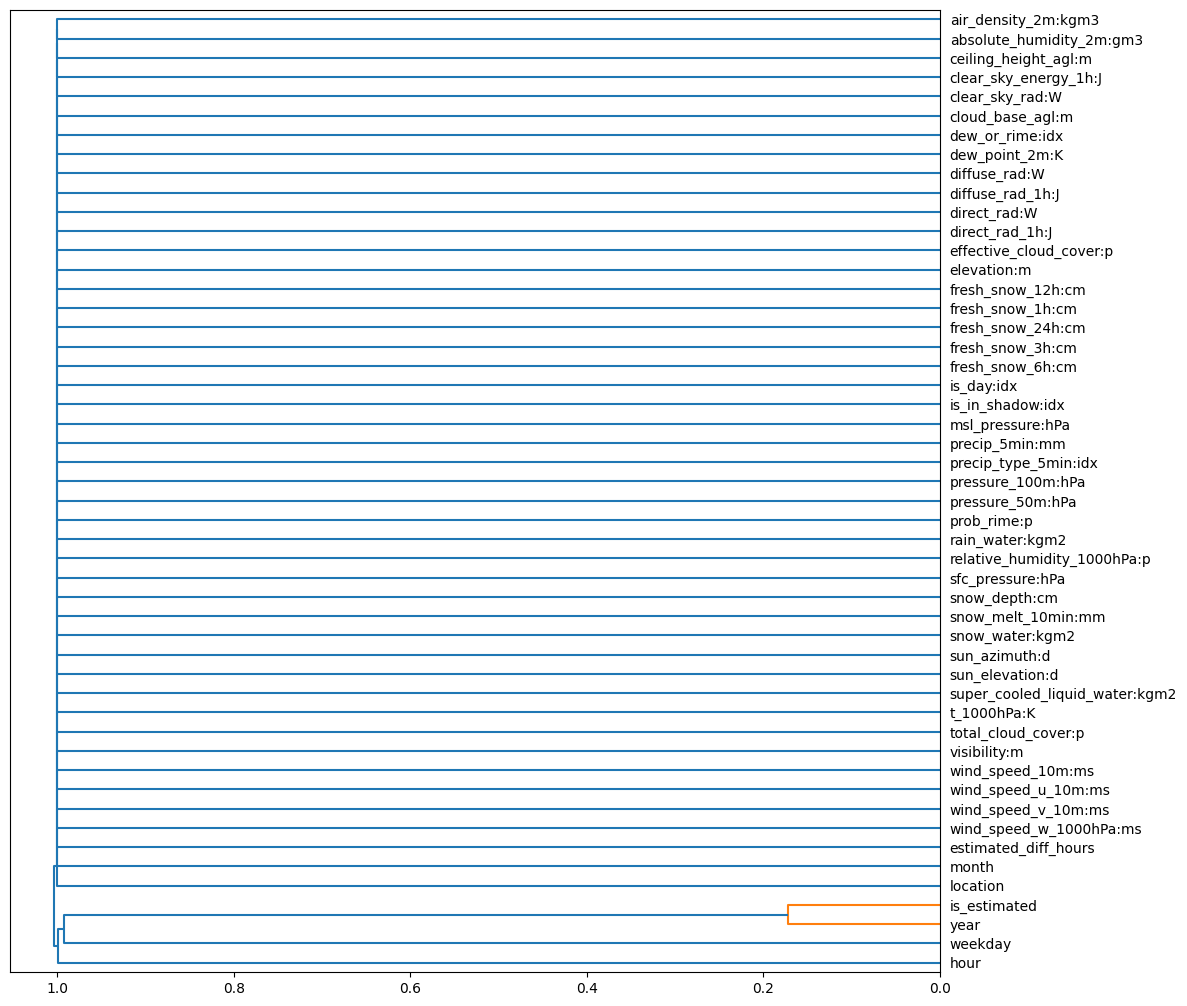

In [13]:
import autogluon.eda.auto as auto
auto.dataset_overview(train_data=X_train, test_data=X_test, label="y", sample=None)

## Target variable analysis

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
y,93024,287.019652,766.407785,-0.0,0.0,0.0,172.92,5733.42,float64,12430,,,float,


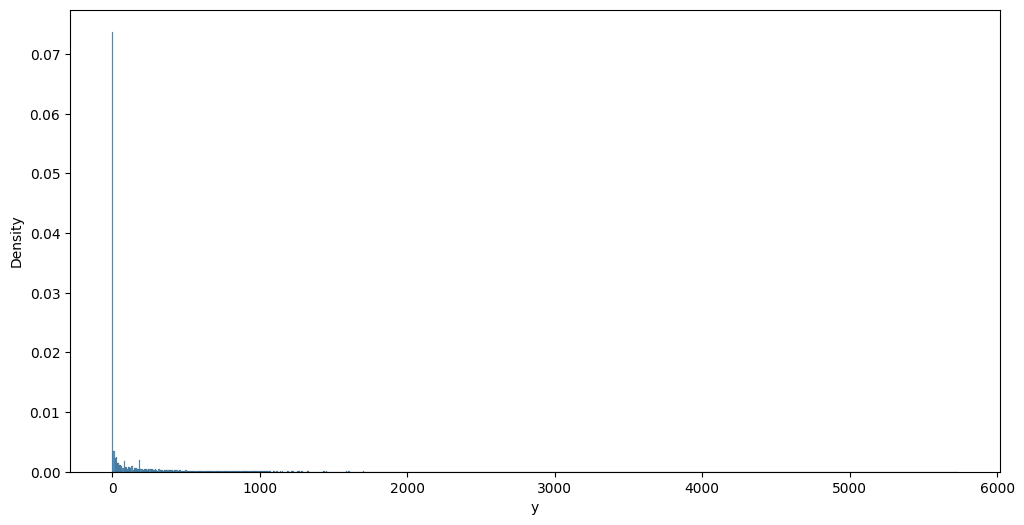

### Distribution fits for target variable
 - ⚠️ none of the [attempted](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) distribution fits satisfy specified minimum p-value threshold: `0.01`

### Target variable correlations

**`train_data` - `spearman` correlation matrix; focus: absolute correlation for `y` >= `0.5`**

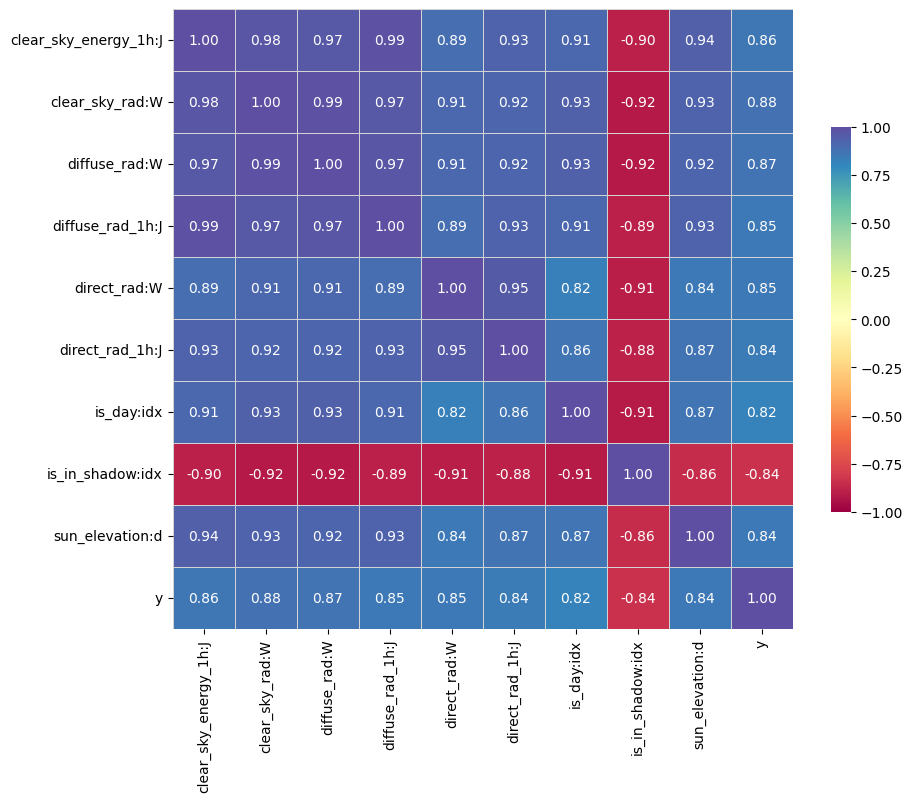

**Feature interaction between `clear_sky_rad:W`/`y` in `train_data`**

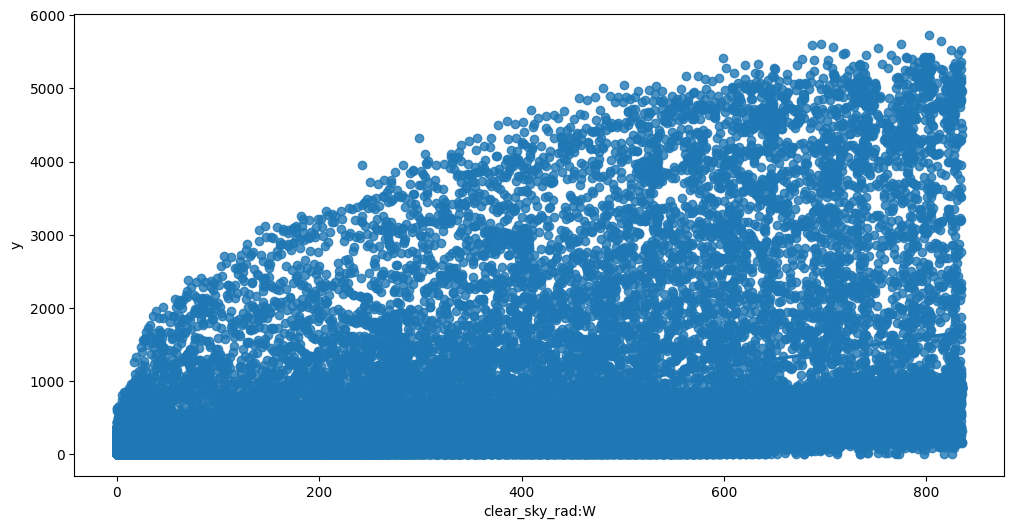

**Feature interaction between `diffuse_rad:W`/`y` in `train_data`**

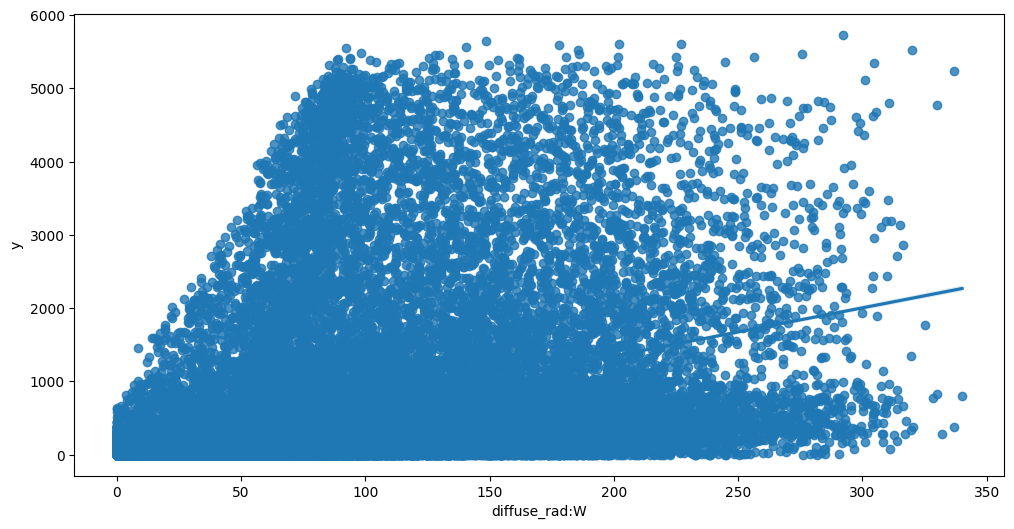

**Feature interaction between `clear_sky_energy_1h:J`/`y` in `train_data`**

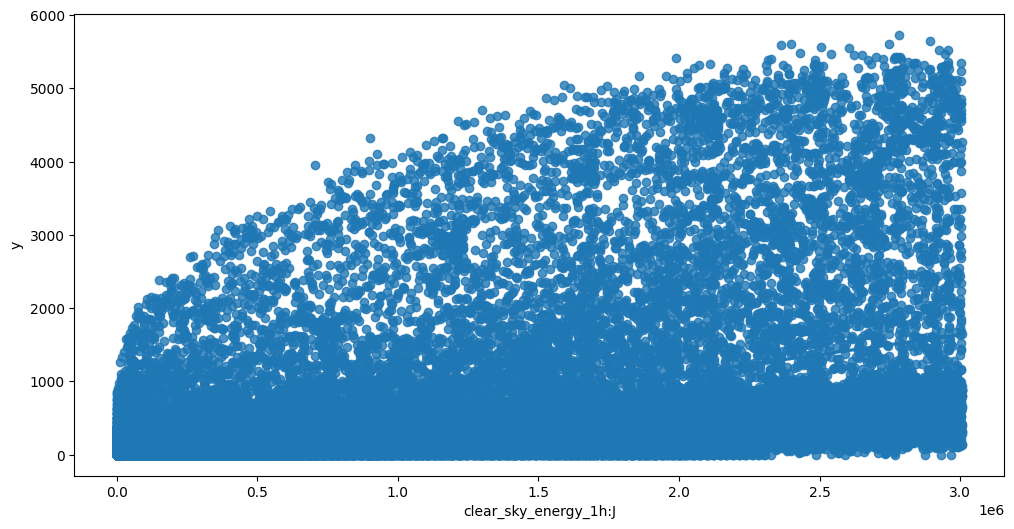

**Feature interaction between `direct_rad:W`/`y` in `train_data`**

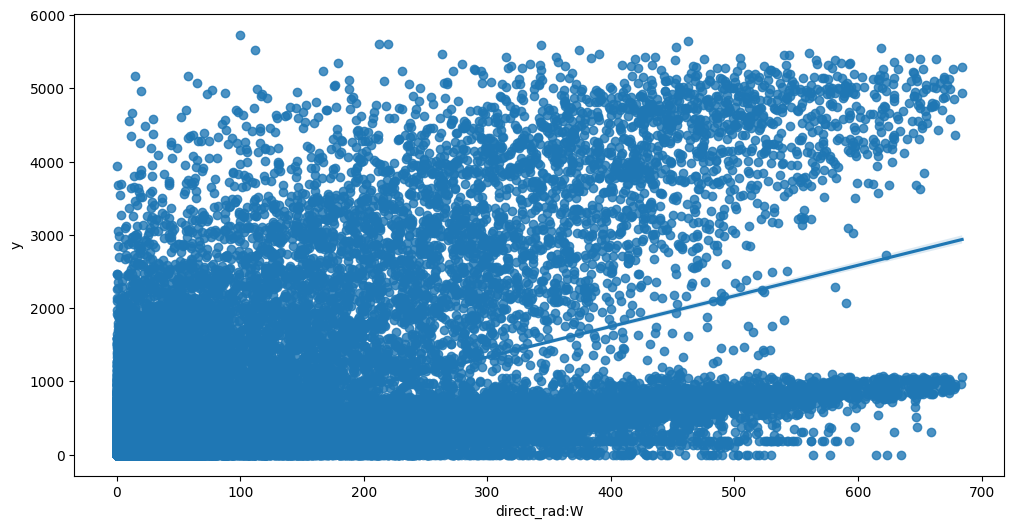

**Feature interaction between `diffuse_rad_1h:J`/`y` in `train_data`**

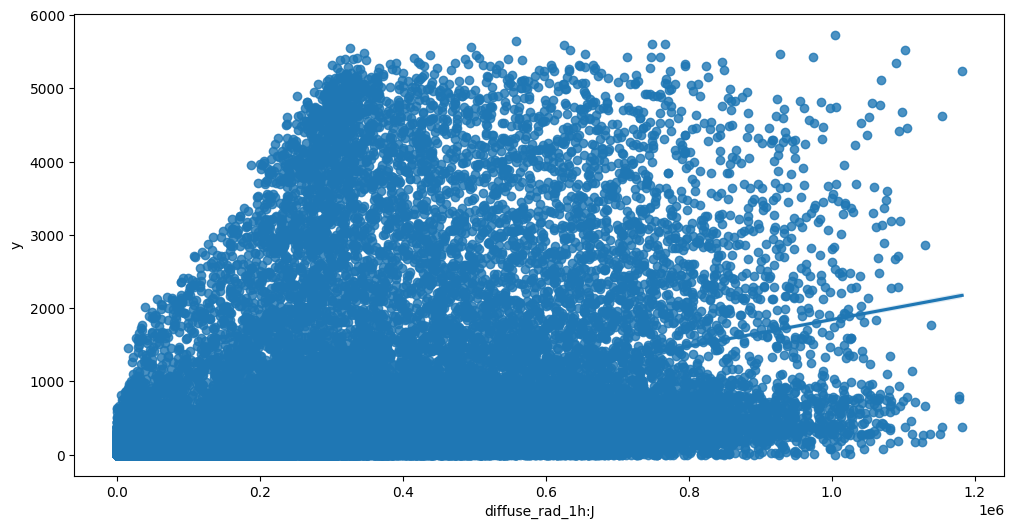

**Feature interaction between `sun_elevation:d`/`y` in `train_data`**

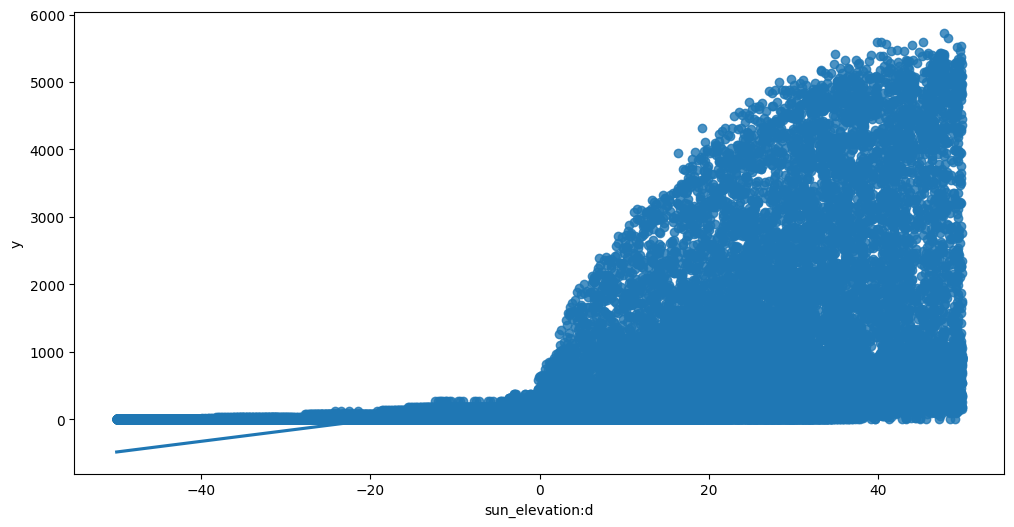

**Feature interaction between `direct_rad_1h:J`/`y` in `train_data`**

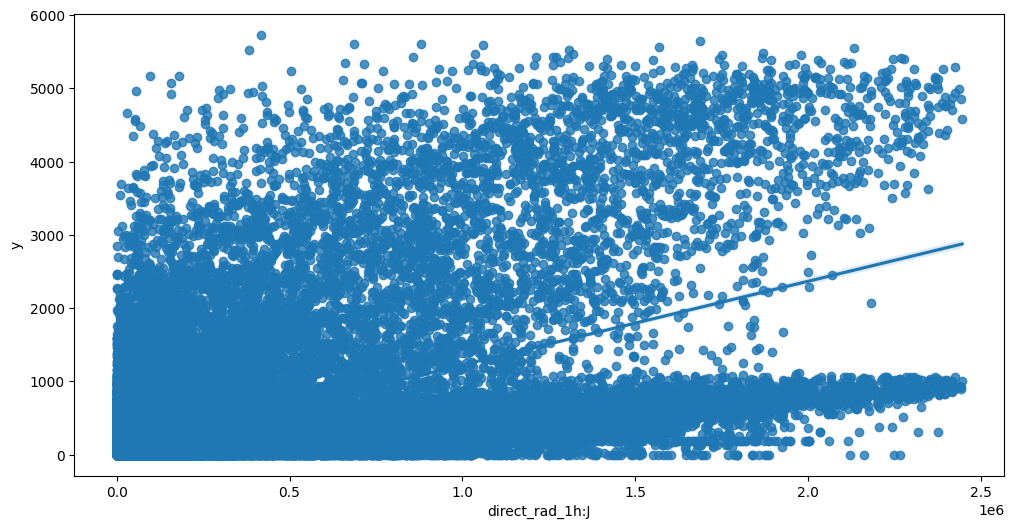

**Feature interaction between `is_day:idx`/`y` in `train_data`**

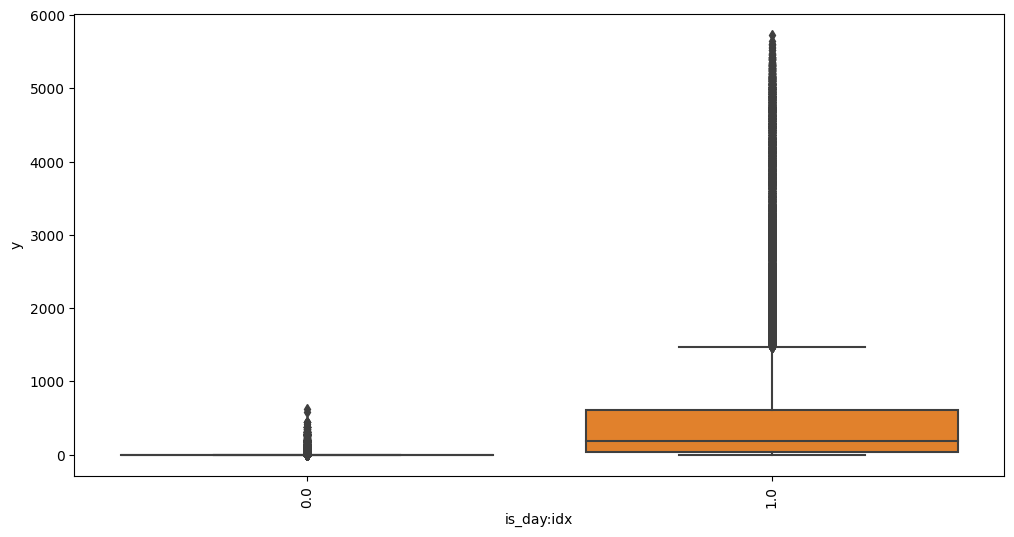

**Feature interaction between `is_in_shadow:idx`/`y` in `train_data`**

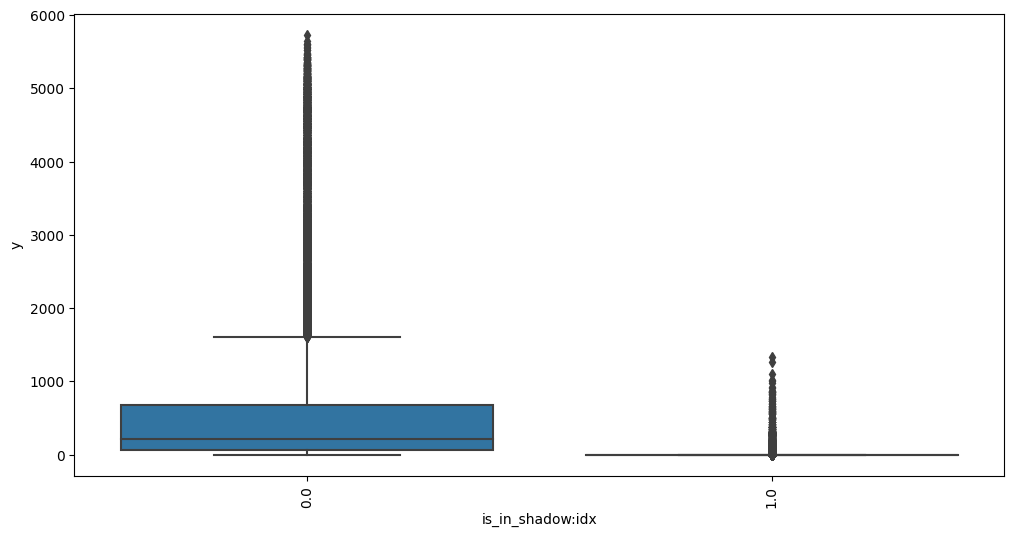

In [5]:
auto.target_analysis(train_data=X_train, label="y")#, sample=None)

No path specified. Models will be saved in: "AutogluonModels/ag-20231007_072957/"


### Model Prediction for y

Using validation data for `Test` points

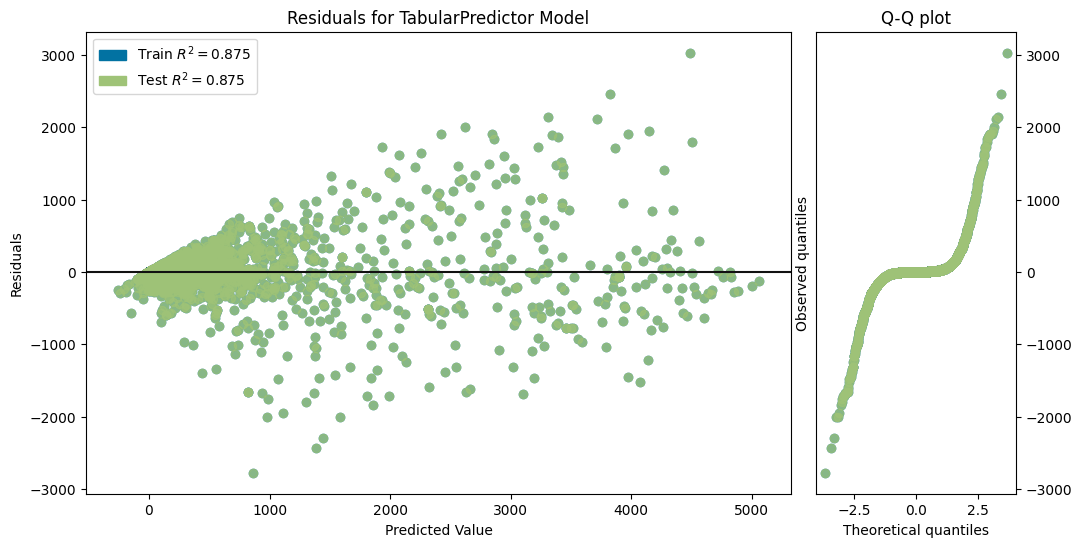

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,-248.750281,-219.751418,0.395301,0.089271,27.446321,0.395301,0.089271,27.446321,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
location,273.036713,13.376774,6.891504e-07,5,300.579676,245.493751
clear_sky_rad:W,120.016183,7.180915,1.530633e-06,5,134.801787,105.230580
direct_rad:W,111.426500,4.257681,2.553141e-07,5,120.193124,102.659875
elevation:m,84.471386,7.655542,8.007653e-06,5,100.234252,68.708520
hour,22.000719,1.605756,3.381223e-06,5,25.306993,18.694445
sun_azimuth:d,14.428784,1.146843,4.749289e-06,5,16.790149,12.067418
clear_sky_energy_1h:J,10.300921,2.154345,2.167830e-04,5,14.736747,5.865094
diffuse_rad:W,9.496224,1.404482,5.578025e-05,5,12.388071,6.604377
sun_elevation:d,9.463388,1.478064,6.914676e-05,5,12.506742,6.420034
direct_rad_1h:J,9.028461,1.675240,1.359428e-04,5,12.477803,5.579119


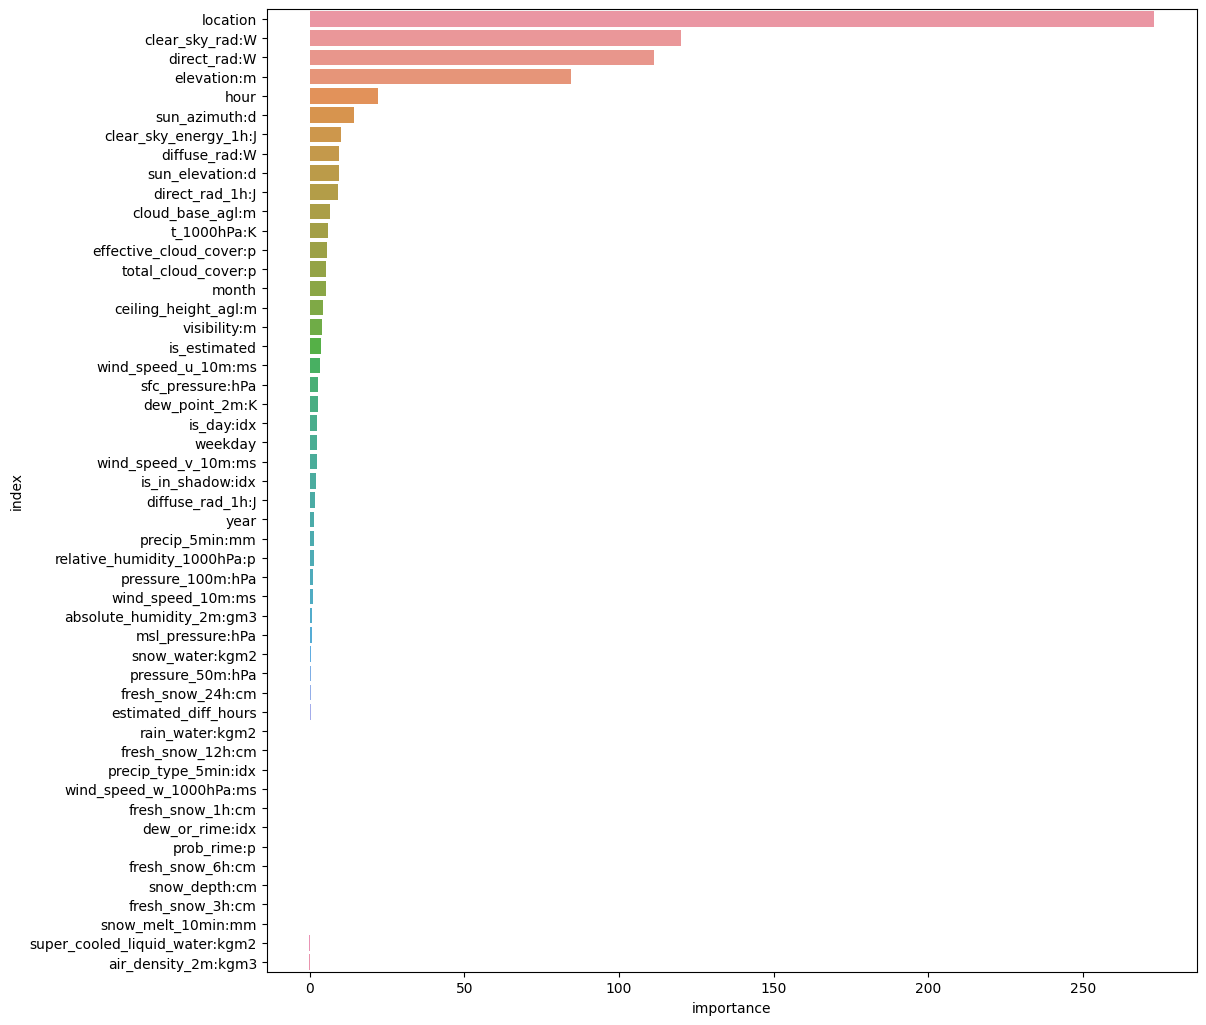

### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,estimated_diff_hours,is_estimated,location,hour,weekday,month,year,y,y_pred,error
ds,,,,,,,,,,,,,,,,,,,,,
2021-07-08 11:00:00,11.1,1.185,8978.200195,2896551.500,818.299988,1731.400024,0.0,286.399994,148.199997,492451.31250,...,0.0,False,A,11,3,7,2021,1450.02,4482.781250,3032.761250
2019-09-01 11:00:00,11.1,1.206,1206.400024,2103079.250,596.599976,1206.400024,0.0,285.899994,130.100006,346342.40625,...,0.0,False,A,11,6,9,2019,3643.20,865.851746,2777.348254
2023-04-16 08:00:00,7.0,1.264,NaN,1344241.625,432.799988,131.699997,0.0,278.700012,105.199997,364302.18750,...,24.0,True,A,8,6,4,2023,1364.44,3820.209473,2455.769473
2022-08-26 08:00:00,12.4,1.200,889.099976,1338429.625,430.700012,620.500000,0.0,287.799988,126.900002,359059.40625,...,0.0,False,A,8,4,8,2022,3821.84,1384.216309,2437.623691
2021-10-05 09:00:00,8.5,1.218,6272.600098,801049.125,264.399994,3214.000000,0.0,281.799988,107.599998,324482.09375,...,0.0,False,A,9,1,10,2021,3742.42,1439.572144,2302.847856
2019-07-09 11:00:00,9.7,1.221,1523.800049,2897436.250,817.900024,1523.800049,0.0,284.000000,226.399994,802221.18750,...,0.0,False,A,11,1,7,2019,1172.60,3311.417969,2138.817969
2021-06-19 07:00:00,7.3,1.229,9630.900391,1675875.500,529.099976,1865.800049,0.0,279.700012,115.800003,387195.90625,...,0.0,False,A,7,5,6,2021,1591.70,3712.722656,2121.022656
2022-06-16 10:00:00,9.9,1.228,2031.800049,2788318.750,803.799988,698.500000,0.0,284.200012,221.199997,754735.12500,...,0.0,False,A,10,3,6,2022,3589.74,1582.717529,2007.022471
2021-07-06 14:00:00,13.4,1.172,3621.699951,2683876.500,706.799988,3180.000000,0.0,289.299988,212.100006,682230.87500,...,0.0,False,A,14,1,7,2021,2983.64,977.366455,2006.273545


In [14]:
auto.quick_fit(X_train, "y", show_feature_importance_barplots=True, val_size=0.3, sample=20000)

# Starting

In [15]:
import os


# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

hello = os.environ.get('HELLO')
if hello is not None:
    new_filename += f'_{hello}'

print("New filename:", new_filename)

Last submission number: 81
Now creating submission number: 82
New filename: submission_82_jorge


In [16]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset('X_train_raw.csv')
train_data.drop(columns=['ds'], inplace=True)

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60*3
presets = 'best_quality'

Loaded data from: X_train_raw.csv | Columns = 52 / 52 | Rows = 136724 -> 136724


In [17]:
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}").fit(train_data, presets=presets, time_limit=time_limit)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 180s
AutoGluon will save models to "AutogluonModels/submission_82_jorge/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   19.68 GB / 494.38 GB (4.0%)
Train Data Rows:    136724
Train Data Columns: 50
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, -0.0, 247.8577, 717.45424)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary',

: 

In [ ]:
predictors = [predictor, predictor, predictor]

# Submit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_with_dates = TabularDataset('X_train_raw.csv')
train_data_with_dates["ds"] = pd.to_datetime(train_data_with_dates["ds"])

test_data = TabularDataset('X_test_raw.csv')
test_data["ds"] = pd.to_datetime(test_data["ds"])
#test_data

In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
test_data_merged = pd.merge(test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in test_data.groupby('location'):
    i = location_map[loc]
    subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

In [ ]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # title
    ax.set_title(f"Predictions for location {loc}")

In [ ]:
# concatenate predictions
submissions_df = pd.concat(predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

In [ ]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)

In [ ]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_all.ipynb"])

In [ ]:
predictor.fit_summary(show_plot=True)

In [ ]:
# feature importance
predictor.feature_importance(feature_stage="original", data=train_data[train_data["location"] == "A"][-24*60*1:])

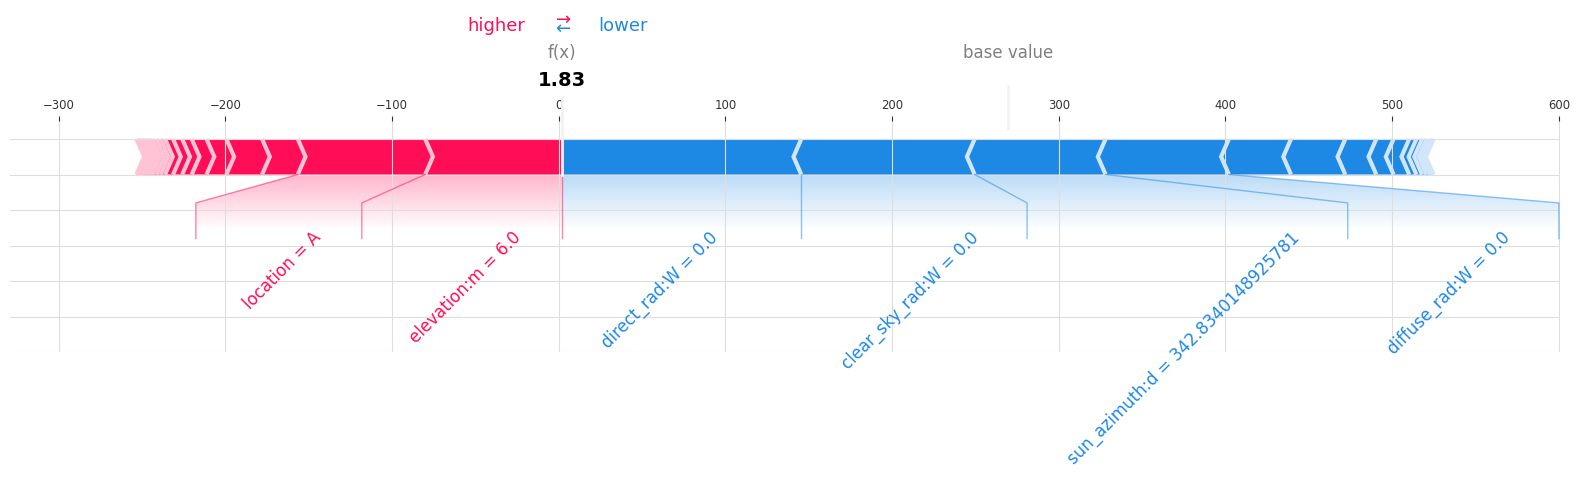

In [ ]:
auto.explain_rows(train_data=X_train, model=predictor, plot="force", rows=X_train[:2])

In [ ]:
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}_with_feature_importance.pdf"), "autogluon_all.ipynb"])